In [1]:
%matplotlib notebook
from pyfeti.src.utils import DomainCreator, dict2dfmap, create_selection_operator, DofManager
from pyfeti.src.feti_solver import SerialFETIsolver, SolverManager
from pyfeti.cases.case_generator import FETIcase_builder
from scipy import sparse
import amfe
import numpy as np
import matplotlib.pyplot as plt
import copy

Could not load paradiso!
Could not load paradiso!
Warning! Using python in global path


In [2]:
buildZ = lambda w,M,K : -w**2*M + K
def build_Z_dict(w,M_dict,K_dict):
    Z_dict = {}
    for key, K in K_dict.items():
        Z_dict[key] = buildZ(w,K,M_dict[key].data)
        
    return Z_dict

<IPython.core.display.Javascript object>


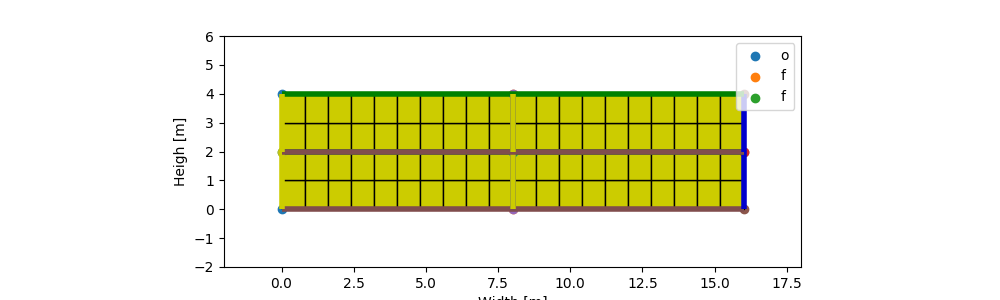

In [3]:
width = 8.
heigh = 2.
divX=11
divY=3
dobj = DomainCreator(width=width,heigh=heigh,x_divisions=divX,y_divisions=divY)
mesh_file = 'mesh.msh'
dobj.save_gmsh_file(mesh_file)

m1 = amfe.Mesh()
m1.import_msh(mesh_file)


domains_X = 2
domains_Y = 2
base = np.array([1,1,1])
facecolor_list = []
mesh_list = []
for my in range(domains_Y):
    for mx in range(domains_X):
        mij = m1.translation(np.array([mx*width,my*heigh]))
        mesh_list.append(mij) 
        facecolor_list.append(0.95*base)
#mesh_list = [m1,m2]

fig1, ax1 = plt.subplots(1,1,figsize=(10,3))

for mi in mesh_list :
    amfe.plot2Dmesh(mi,ax=ax1)

ax1.set_xlim([-2,domains_X*width+2])
ax1.set_ylim([-2,domains_Y*heigh+2])
ax1.set_aspect('equal')
ax1.set_xlabel('Width [m]')
ax1.set_ylabel('Heigh [m]')
plt.legend('off')

In [4]:
# creating material
my_material = amfe.KirchhoffMaterial(E=210.0E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1.0)

my_system1 = amfe.MechanicalSystem()
my_system1.set_mesh_obj(m1)
my_system1.set_domain(3,my_material)

K1, _ = my_system1.assembly_class.assemble_k_and_f()
M1 = my_system1.assembly_class.assemble_m()


system_list = []
for mi in mesh_list:
    sysi = amfe.MechanicalSystem()
    sysi.set_mesh_obj(mi)
    sysi.set_domain(3,my_material)
    system_list.append(sysi)
    
try:
    connectivity = []
    for _,item in m1.el_df.iloc[:, m1.node_idx:].iterrows():
        connectivity.append(list(item.dropna().astype(dtype='int64')))
    m1.el_df['connectivity'] = connectivity
except:
    pass
    
id_matrix = my_system1.assembly_class.id_matrix
id_map_df = dict2dfmap(id_matrix)
s = create_selection_operator(id_map_df,m1.el_df)

neighbors_dict = {}
neighbors_dict['right'] = 2
neighbors_dict['left'] = 1
neighbors_dict['top'] = 5
neighbors_dict['bottom'] = 4
neighbors_dict['bottom_left_corner'] = 6
neighbors_dict['bottom_right_corner'] = 7
neighbors_dict['top_left_corner'] = 8
neighbors_dict['top_right_corner'] = 9

B_local_dict = {}
for key, value in neighbors_dict.items():
    B_local_dict[key] = s.build_B(value)

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 20 elements and 66 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 20 elements and 66 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 20 elements and 66 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 20 elements and 66 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 20 elements and 66 dofs.
Time taken for preallocation: 0.00 seconds.


In [5]:
zeros = np.zeros(K1.shape[0])
case = FETIcase_builder(domains_X,domains_Y, K1, zeros, B_local_dict,s,BC_type='G',force_scaling=1.0)
K_dict, B_dict, f_dict = case.build_subdomain_matrices()

M_dict = {}
for i in range(len(mesh_list)):
    M_dict[i+1] = M1
    
#K_dict = {1:K1, 2:K2}
feti_obj1 = SerialFETIsolver(K_dict,B_dict,f_dict,tolerance=1.0e-12)
feti_obj2 = SerialFETIsolver(M_dict,B_dict,f_dict,tolerance=1.0e-12)
manager = feti_obj1.manager 
managerM = feti_obj2.manager
Mi = managerM.local_problem_dict[1].K_local
Mi.key_dict = s.selection_dict
Mi.eliminate_by_identity(1,multiplier=0.0)
for i in range(len(mesh_list)):
    M_dict[i+1] = copy.deepcopy(Mi)

In [6]:
def system(Z_dict,tol=1.0e-8):
        
    #f_dict = manager.vector2localdict(f,manager.global2local_primal_dofs)
    feti_obj = SerialFETIsolver(Z_dict,B_dict,f_dict,tolerance=tol)
    solution_obj = feti_obj.solve()
    u_dict = solution_obj.u_dict
    return np.abs(solution_obj.displacement), u_dict

In [7]:

f4 = B_local_dict['top_right_corner'].T.dot([0.0,-100000000.0])
f1 = 0.0*f4
f2 = 0.0*f4
f3 = 0.0*f4
f_dict = {1:f1,2:f2,3:f3,4:f4}


In [14]:
w_list = 2.0*np.pi*np.linspace(0.1,200,100)


In [15]:
w_list

array([6.28318531e-01, 1.33152755e+01, 2.60022325e+01, 3.86891895e+01,
       5.13761465e+01, 6.40631035e+01, 7.67500605e+01, 8.94370175e+01,
       1.02123975e+02, 1.14810932e+02, 1.27497889e+02, 1.40184846e+02,
       1.52871803e+02, 1.65558760e+02, 1.78245717e+02, 1.90932674e+02,
       2.03619631e+02, 2.16306588e+02, 2.28993545e+02, 2.41680502e+02,
       2.54367459e+02, 2.67054416e+02, 2.79741373e+02, 2.92428330e+02,
       3.05115287e+02, 3.17802244e+02, 3.30489201e+02, 3.43176158e+02,
       3.55863115e+02, 3.68550072e+02, 3.81237029e+02, 3.93923986e+02,
       4.06610943e+02, 4.19297899e+02, 4.31984856e+02, 4.44671813e+02,
       4.57358770e+02, 4.70045727e+02, 4.82732684e+02, 4.95419641e+02,
       5.08106598e+02, 5.20793555e+02, 5.33480512e+02, 5.46167469e+02,
       5.58854426e+02, 5.71541383e+02, 5.84228340e+02, 5.96915297e+02,
       6.09602254e+02, 6.22289211e+02, 6.34976168e+02, 6.47663125e+02,
       6.60350082e+02, 6.73037039e+02, 6.85723996e+02, 6.98410953e+02,
      

In [16]:
B_obj = B_local_dict['bottom_right_corner']

u_list = []
u_obj_list = []
for w in w_list:
    Z_dict = build_Z_dict(w,M_dict,K_dict)
    u0, u_dict = system(Z_dict,tol=1.0e-8)
    
    u_list.append(u0)
    u_obj_list.append(np.abs(B_obj.dot(u_dict[2])))

<IPython.core.display.Javascript object>


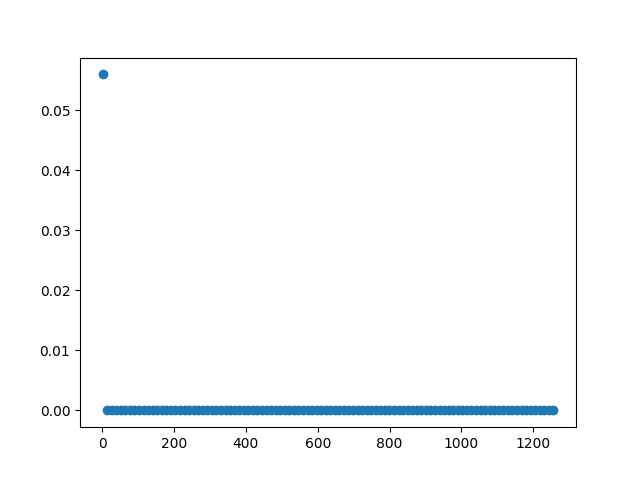

In [17]:
plt.figure()
plt.plot(w_list,np.array(u_obj_list).T[0,:],'o')

In [12]:
M_dict[1]

In [13]:
f4

array([ 0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00, -1.e+08])